# Path planning with A*
The [A* algorithm](https://en.wikipedia.org/wiki/A*_search_algorithm) is a workhorse in many search problems where exhaustive search is not feasible or practical.  It is a simple extension of [Best-first search](https://en.wikipedia.org/wiki/Best-first_search) in which a heuristic is used to estimate the remaining cost-to-go for all open nodes.  In order to guarantee that `A*` will return the optimal solution, the heuristic must be [admissible](https://en.wikipedia.org/wiki/A*_search_algorithm#Admissibility_and_optimality); essentially, it must be never underestimate the cost-to-go.  In [path planning problems](https://en.wikipedia.org/wiki/Pathfinding), a subset of [graph search](https://en.wikipedia.org/wiki/Graph_traversal), a simple an clear heuristic is readily available: the [Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the current position and the goal - there cannot be a shorter path.  

As possible paths between the current position and the goal are explored, partial paths are expanded in the order of their total estimated cost to the goal: the distance travelled so far + the estimated distance remaining.

## Simplifications in this simulation
* The robot can view the entire world, and all obstacles.  
* The simulation uses a binary traversal cost map - that is, each cell in the map is either passable or not.
* The robot is modeled as a point - there is no consideration for the geometry of its hull, or its orientation.
* The simulation assumes an omnidirectional robot, or one that can turn "on the spot" at no cost.

In a real-world navigation scenario, none of these simplifications would be possible.  [Here](https://youtu.be/mAdLkBWkdgE) is a simulation with proper modeling of obstacle visibility, vehicle turning and acceleration dynamics, and "soft" traversal cost map, which encourages navigation around obstacles with a safety cushion.  [Here](https://www.youtube.com/watch?v=lKpBxCOVU0o&index=3&list=PL_G5aRg1QysiqW8O-O7rUtK0nyylZ9HKo) is a live example of an autonomous robotic platform using `A*` to navigate an obstacle course.

## Algorithm implementation

In [1]:
from queue import PriorityQueue 


class World(object):
    OBST = -1
    UNINITIALIZED = -2
    
    def __init__(self, height=10, width=10):
        self.map = np.ones((height, width)) * self.UNINITIALIZED
        self.robot = None
        self.goal = None
        
        
class Path(object):
    def __init__(self, world, path, cost_so_far):
        self.world = world
        self.path = path
        self.cost_so_far = cost_so_far
        self.heuristic = self.distance(self.path[-1], self.world.goal)
        self.total_cost = self.cost_so_far + self.heuristic
        
    def valid(self):
        cost = 0
        for p1, p2 in zip(self.path, self.path[1:]):
            cost += self.distance(p1, p2)            
            if self.world.map[p2] != World.UNINITIALIZED:
                if self.world.map[p2] < cost:
                    return False
                elif p2 == self.path[-1] and self.world.map[p2] == cost:
                    return False
        
        return True
    
    @classmethod
    def distance(cls, p1, p2):
        return np.linalg.norm(np.array(p1) - np.array(p2))
        
    def children(self):
        children = []
        y, x = self.path[-1]
        for xx in range(max(0, x - 1), min(len(self.world.map[0]), x + 2)):
            for yy in range(max(0, y - 1), min(len(self.world.map), y + 2)):
                step = yy, xx
                if self.world.map[step] != World.OBST and step not in self.path:
                    child = Path(self.world,
                                 self.path + [step], 
                                 self.cost_so_far + self.distance(step, self.path[-1]))
                    if child.valid():
                        children.append(child)
        return children
    
    def __lt__(self, other):
        if self.total_cost == other.total_cost:
            d1 = self.distance(self.path[-1], self.world.goal)
            d2 = self.distance(other.path[-1], self.world.goal)
            if d1 < d2:
                return True
        else:
            if self.total_cost < other.total_cost:
                return True
        

class Astar(object):
    def __init__(self, world):
        self.world = world
        self.best_path = None
        self.q = PriorityQueue()
        seed = Path(world, [world.robot], 0)
        self.q.put(seed)

    def next(self):
        p = self.q.get()
        
        # check to see if this node is still valid (have we seen another path
        # that passes through this path's end position)
        while not self.q.empty() and not p.valid():
            p = self.q.get()
                    
        if p.path[-1] == self.world.goal:
            self.best_path = p
        else:
            self.world.map[p.path[-1]] = p.cost_so_far
            for child in p.children():
                self.q.put(child)
                
        return p

### Visualization
Let's take a peek at what a random world looks like after some exploration.  Generate some random maps, and click on cells to turn obstacles on/off.  Some maps will not have solutions!

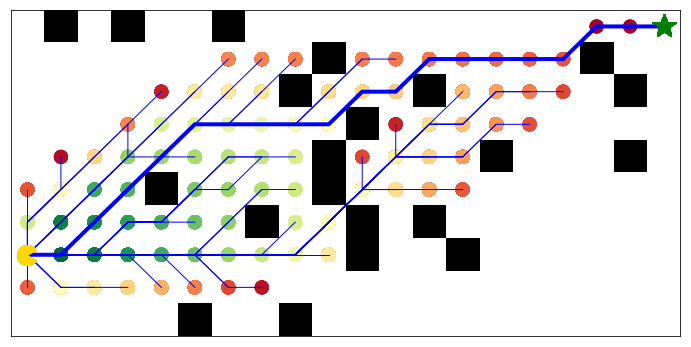

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pylab as plt
from ipywidgets import widgets
from IPython import display
import numpy as np


rows = 10
cols = 20
def make_toggles(n, radio=False, icon=''):
    toggles = [widgets.ToggleButton(value=False, icon=icon) for _ in range(n)]
    if radio:
        def make_reset(t):
            def reset_others(change):
                if change['name'] == 'value' and change['new'] == True:
                    for tt in toggles:
                        if tt != t:
                            tt.value = False
            return reset_others
        for t in toggles:
            t.observe(make_reset(t))
    return toggles


robot_container = widgets.VBox(make_toggles(rows, radio=True, icon='fa-android'))
map_container = widgets.VBox([widgets.HBox(make_toggles(cols - 2)) for _ in range(rows)])
goal_container = widgets.VBox(make_toggles(rows, radio=True, icon='fa-flag'))
master_container = widgets.HBox([robot_container, map_container, goal_container])
display.display(master_container)


def randomize_world(caller=None):
    def randomize_container(container, n_true=1):
        for t in container.children:
            t.value = False
        for _ in range(n_true):
            container.children[np.random.randint(len(container.children))].value = True

    pct_obstacle = 0 if caller == clear_btn else .2
    randomize_container(robot_container, n_true=1)
    randomize_container(goal_container, n_true=1)
    for row in map_container.children:
        randomize_container(row, n_true=int(np.ceil(np.random.randint(len(row.children)) * pct_obstacle)))
    
    
def make_world_from_toggles():
    world = World(height=rows, width=cols)
    for y, row in enumerate(map_container.children): 
        for x, toggle in enumerate(row.children):
            if toggle.value:
                world.map[y, x + 1] = World.OBST
    
    for y, toggle in enumerate(robot_container.children):
        if toggle.value:
            world.robot = y, 0

    for y, toggle in enumerate(goal_container.children):
        if toggle.value:
            world.goal = y, cols - 1
    
    return world
    

def plot_world(world, path=None, path_color='b', path_width=1, ax=None):
    if not ax:
        plt.figure(figsize=(12, 6))
        plt.xticks([])
        plt.yticks([])
        ax = plt.gca()
        obst_map = np.vectorize(lambda x: 0 if x == world.OBST else 255)(world.map)
        ax.imshow(obst_map, cmap='gray', interpolation='nearest', aspect='auto')
        plt.autoscale(False)
        

    path_points = np.where(world.map > 0)
    if path_points:
        # the world map has the lowest-observed partial path cost to each position;
        # add the heuristic (remaining distance to goal) to get the full node cost
        cost = world.map[path_points] + list(map(lambda y, x: Path.distance(world.goal, [y, x]), *path_points))
        ax.scatter(path_points[1], path_points[0], c=-cost, 
                   edgecolor='none', marker='o', cmap='RdYlGn', s=200)

    if path:
        y, x = zip(*path.path)
        ax.plot(x, y, path_color, lw=path_width)

    # make a pacman path for the robot icon
    thetas = np.linspace(30*np.pi/180, 330*np.pi/180, 20)
    verts = list(map(lambda t: [np.cos(t), np.sin(t)], thetas))
    verts += [[0, 0], verts[0]]
    pacman = matplotlib.path.Path(verts)

    ax.plot(world.robot[1], world.robot[0], color='gold', marker=pacman, markersize=20)
    ax.plot(world.goal[1], world.goal[0], color='g', marker='*', markersize=25)
        
    return ax    

    
def simulate(caller):
    display.clear_output(wait=True)
    world = make_world_from_toggles()
    astar = Astar(world)
    ax = plot_world(world)
    for _ in range(1000):
        p = astar.next()
        if astar.best_path:
            plot_world(world, p, 'b', 4, ax)
        else:
            plot_world(world, p, 'b', 1, ax)
            
        if astar.q.empty() or astar.best_path:
            break

            
def animate(caller):
    display.clear_output(wait=True)
    from matplotlib import animation
    from IPython.display import HTML

    world = make_world_from_toggles()
    astar = Astar(world)
    ax = plot_world(world)

    def init():
        plot_world(world, ax=ax)

    def animate(frame_no):
        p = astar.next()
        if astar.best_path:
            plot_world(world, p, 'b', 4, ax)
        else:
            plot_world(world, p, 'b', 1, ax)

    def frames():
        frame = 0
        while not astar.best_path and frame < 1000:
            frame += 1
            yield frame
        
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=init, frames=frames, save_count=1<<32)
    display.display(HTML(anim.to_html5_video()))
    

rand_btn = widgets.Button(description='Randomize')
rand_btn.on_click(randomize_world)
clear_btn = widgets.Button(description='Clear')
clear_btn.on_click(randomize_world)

sim_btn = widgets.Button(description='Simulate')
sim_btn.on_click(simulate)
anim_btn = widgets.Button(description='Animate')
anim_btn.on_click(animate)

randomize_world()
display.display(widgets.HBox([rand_btn, clear_btn, sim_btn, anim_btn]))